In [1]:
import copy
import numpy as np

from cv2 import imread, cvtColor, COLOR_BGR2GRAY
from cv2 import resize

import matplotlib.pyplot as plt

from numba import njit
from time import time, ctime

In [2]:
@njit
def iteration(FBin, WBin, NBin, Map, Vsize):
    
    # BFS
    Q = [0] # Queue that start with S
    Prev = np.full(Vsize, -1) # Prev node
    cursor = 0 # instead of popping elements of of the Q
    
    while True:
        v_curr = Q[cursor]
        for i, neighbour in enumerate(NBin[Map[v_curr,0]:Map[v_curr,1]]):
            #print(f"{V[v_curr]} | neighbour: {neighbour} | Weights: {Weights[v_curr][i]} | {F[v_curr]} ? {Weights[v_curr][i]}")

            if FBin[Map[v_curr,0]:Map[v_curr,1]][i] < WBin[Map[v_curr,0]:Map[v_curr,1]][i] and Prev[neighbour] == -1:
                Q.append(neighbour)
                Prev[neighbour] = v_curr
        cursor += 1
        if cursor >= len(Q):
            break
    
    
    # path reconstruction
    v_curr = Vsize - 1
    path = [v_curr]
    while True:
        v_prev = Prev[v_curr]
        v_curr = v_prev
        if v_curr == -1 : break
        path.append(v_curr)

    path = path[::-1]
    
    
    # path bottleneck
    bottleneck = np.inf
    for i in range(len(path) - 1):
        v_curr = path[i]
        v_next = path[i+1]

        ind = np.where( NBin[Map[v_curr,0]:Map[v_curr,1]] == v_next)[0][0]
        if WBin[Map[v_curr,0]:Map[v_curr,1]][ind] < bottleneck: 
            bottleneck = WBin[Map[v_curr,0]:Map[v_curr,1]][ind]
    
    
    # End break
    if bottleneck == np.inf : return FBin, True
    
    # path flow update
    for i in range(len(path) - 1):
        v_curr = path[i]
        v_next = path[i+1]

        ind = np.where( NBin[Map[v_curr,0]:Map[v_curr,1]] == v_next)[0][0]
        FBin[Map[v_curr,0]:Map[v_curr,1]][ind] += bottleneck
    
    #print('')
    #print('----- New iteration -----')
    #print('Bottleneck is: ', bottleneck)
    
    return FBin, False

---

## Input

Input size:  (128, 128)


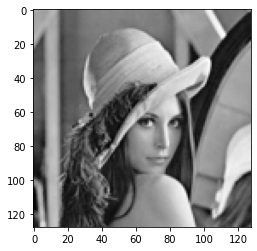

In [3]:
img = cvtColor( imread("input.png"), COLOR_BGR2GRAY)
#img = resize(img, (32,32))
h, w = img.shape

print('Input size: ',img.shape)
plt.imshow(img, cmap='gray')

In [4]:
value = 50

In [5]:
Vsize = h*w + 2

## Init

In [6]:
start2 = time()

In [7]:
g = np.zeros((h*w + 2, h*w + 2), dtype = np.int32)

In [8]:
g[0, 1:-1] = img.flatten()
g[1:-1, -1] = 255 - img.flatten()
for i in range(h):
    for j in range(w):
        index = j + i*w + 1
        #print(index)
        # left
        if j > 0:
            left_index = j - 1 + i*w + 1
            g[left_index, index] = value
        # right
        if j < w - 1:
            right_index = j + 1 + i*w + 1
            g[right_index, index] = value
         # up
        if i > 0:
            up_index = j + (i-1)*w + 1
            g[up_index, index] = value
        # down
        if i < h - 1:
            down_index = j + (i+1)*w + 1
            g[down_index, index] = value

In [9]:
np.where(g[3] > 0)[0]

array([    2,     4,   131, 16385], dtype=int64)

In [10]:
g[45]

array([  0,   0,   0, ...,   0,   0, 121])

In [11]:
bin_size = g[g > 0].shape[0]
    
NBin = np.full((bin_size), -1)
WBin = np.full((bin_size), -1)
FBin = np.full((bin_size), -1)

Map = np.full((g.shape[0],2), -1)

start = 0
for i in range(g.shape[0]):
    end = start + g[i][g[i] > 0].shape[0]

    Map[i] = [start, end]
    
    NBin[start:end] = np.array(np.where(g[i] > 0)[0])
    WBin[start:end] = np.array(g[i][g[i] > 0])
    FBin[start:end] = 0
    
    start = end

---

## Main

In [12]:
while True:
        FBin, end = iteration(FBin, WBin, NBin, Map, Vsize)
        if end : break

end2 = time()
print('Time: ', end2 - start2)

Time:  12.101416826248169


---

## MinCut

In [13]:
# BFS
Q = [0] # Queue that start with S
Prev = np.full(Vsize, -1) # Prev node
cursor = 0 # instead of popping elements of of the Q

while True:
    v_curr = Q[cursor]
    for i, neighbour in enumerate(NBin[Map[v_curr,0]:Map[v_curr,1]]):
        #print(f"{V[v_curr]} | neighbour: {neighbour} | Weights: {Weights[v_curr][i]} | {F[v_curr]} ? {Weights[v_curr][i]}")

        if FBin[Map[v_curr,0]:Map[v_curr,1]][i] < WBin[Map[v_curr,0]:Map[v_curr,1]][i] and Prev[neighbour] == -1:
            Q.append(neighbour)
            Prev[neighbour] = v_curr
    cursor += 1
    if cursor >= len(Q):
        break
        
min_cut = np.array(Q, dtype=np.int32)
#print('MinCut: ', min_cut)

In [14]:
res = np.zeros((h*w), dtype=np.uint8)

for v_ind in min_cut:
    res[v_ind] = 1

res = np.reshape(res, (h, w))

Time:  12.101416826248169


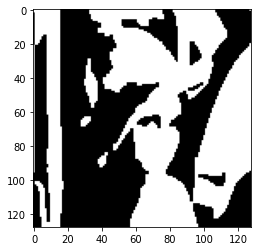

In [15]:
plt.imshow(res, cmap='gray')
print('Time: ', end2 - start2)